# CS-E5740 Complex Networks, Fall 2018 - Course project
Adam 725819

<a id='content'></a>
[Task 1: Basic implementation](#task1)

[Task 2: Effect of infection probability $p$ on spreading speed](#task2)

[Task 3: Effect of seed node selection on spreading speed](#task3)

[Task 4: Where to hide?](#task4)

[Task 5: Shutting down airports](#task5)

[Task 6: Disease transmitting link](#task6)



In [1]:
import numpy as np
import networkx as nx
import pandas as pd

import pickle

The flight data that you will use to perform your simulation is located in file
`events_US_air_traffic_GMT.txt` with the following columns

- Source [0-278], 
- Destination [0-278]
- Start Time (GMT) [seconds after Unix epoch time]
- End Time (GMT)
- Duration [Same as (EndTime-StartTime)]

In [2]:
event_data = pd.read_csv('events_US_air_traffic_GMT.txt', sep=' ')
event_data.head()

,Source,Destination,StartTime,EndTime,Duration
0,0,1,1229286900,1229291520,4620
1,0,1,1229272800,1229277300,4500
2,0,2,1229285640,1229291520,5880
3,0,3,1229268060,1229276040,7980
4,0,3,1229284740,1229293140,8400


The aggregated weighted network `aggregated_US_air_traffic_network_undir.edg` is constructed based on the event data, so that weight of each link corresponds to the number of
flights between the nodes. 

Additionally, you can find the information about the airports in file
`US_airport_id_info.csv`

<a id='task1'></a>
## Task 1: Basic implementation

Implement the SI model using the temporal air traffic data. Use the provided visualization
module to check that your implementation works reasonably. Assume first that $p = 1$, i.e., the
disease is always transmitted.

### If Allentown (node-id=0) is infected at the beginning of the data set, at which time does Anchorage (ANC, node-id=41) become infected?
Hint: The time point should fall within the range 
`1229290000-1229291000`

In [17]:
def load_data():
    event_data = pd.read_csv('events_US_air_traffic_GMT.txt', sep=' ')
    event_data = event_data.sort_values(by=['StartTime', 'EndTime'], ascending=[True, True])
    event_data['Source'] = event_data['Source'].astype(str)
    event_data['Destination'] = event_data['Destination'].astype(str)
    return event_data.reset_index(drop=True)

event_data = load_data()
event_data.head()

,Source,Destination,StartTime,EndTime,Duration
0,27,49,1229231100,1229246760,15660
1,30,2,1229233200,1229245980,12780
2,251,20,1229235000,1229246340,11340
3,12,4,1229235300,1229244960,9660
4,180,20,1229235300,1229245500,10200


In [23]:
def load_and_init_graph(nodes='0'):
    graph = nx.read_weighted_edgelist('./aggregated_US_air_traffic_network_undir.edg')
    
    infection_times = {node: float('inf') for node in graph.nodes()}
    nx.set_node_attributes(graph, infection_times, 'infection_time')
    
    if type(nodes) == str:
        assert graph.has_node(nodes)
        # first node to be infected
        graph.nodes[nodes]['infection_time'] = min(event_data['StartTime'])
        
    elif type(nodes) in [list, np.ndarray]:
        for node in nodes:
            assert graph.has_node(node)
            
        for node in nodes:
            graph.nodes[node]['infection_time'] = min(event_data['StartTime'])
            
    return graph

graph = load_and_init_graph()
graph.nodes['0']

{'infection_time': 1229231100}

In [27]:
# all node is inf
# except node 0: first start time
# node is infected only if its infection time is smaller than start time

def simulate_infection(p=1, seed_nodes='0'):
    event_data = load_data()
    graph = load_and_init_graph(seed_nodes)
    
    for index in event_data.index:
        row = event_data.iloc[index]
        source, destination, start, end, duration = tuple(row)
        if (start >= graph.nodes[source]['infection_time']) and (np.random.rand() <= p):
            # only update if new infection time is smaller than target nodes infection time
            if end < graph.nodes[destination]['infection_time']:
                graph.nodes[destination]['infection_time'] = end # update
    return graph

graph = simulate_infection(p)
node = '41'
print('Node %s is infected at time: %s' % (node, graph.nodes['41']['infection_time']))

Node 41 is infected at time: 1229290800


[Back to content](#content)
<a id='task2'></a>
## Task 2: Effect of infection probability $p$ on spreading speed

Run the SI-model 10 times with each of the infection probabilities [0.01, 0.05, 0.1, 0.5, 1.0].
Again, let Allentown (node-id=0) be the initially infected node. Record all infection times of
the nodes, and answer the following questions:

### a) Plot the averaged prevalence $\rho(t)$ of the disease (fraction of infected nodes) as a function of time for each of the infection probabilities. Plot the 5 curves in one graph.


In [47]:
# fraction of nodes infected as a function of time
# For creating the time axis, divide the whole time spam, 
# from the first departure to the last arrival, into equal-sized steps
# For each step, you should be able to calculate, how many nodes on average were infected before that step. 
# To obtain the prevalence, normalize by the number of nodes.

def calc_prevalence(graph, steps=10):
    N = len(graph.nodes)
    prevalence = []
    timestamps = np.linspace(min(event_data['StartTime']), max(event_data['EndTime']), steps)
    for time in timestamps:
        n_infected = len([graph.nodes[node] for node in graph.nodes if graph.nodes[node]['infection_time'] <= time])
        prevalence.append(n_infected/N)
    return prevalence

steps = 20
prevalence = calc_prevalence(graph, steps)
print(prevalence)

[0.0035842293906810036, 0.7275985663082437, 0.982078853046595, 0.992831541218638, 0.992831541218638, 0.992831541218638, 0.992831541218638, 0.992831541218638, 0.992831541218638, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [63]:
infection_probs = [0.01, 0.05, 0.1, 0.5, 1.0]
prevalence_averages = {}

for p in infection_probs:
    print("Calc. for p = %s" % p)
    store_prevalence = []
    for _ in range(10):
        graph = simulate_infection(p, False)
        prevalence = calc_prevalence(graph, 20)
        store_prevalence.append(prevalence)
        
    prevalence_averages[p] = [np.mean(prevalence) for prevalence in zip(*store_prevalence)]

Calc. for p = 0.01
Calc. for p = 0.05
Calc. for p = 0.1
Calc. for p = 0.5
Calc. for p = 1.0


In [67]:
#import json
#with open('prevalence.json', 'w') as outfile:
#    json.dump(prevalence_averages, outfile)

for p in prevalence_averages:
    print(p)
    print(prevalence_averages[p])

0.01
[0.0035842293906810036, 0.0039426523297491035, 0.005734767025089606, 0.011469534050179211, 0.021863799283154125, 0.048387096774193554, 0.06415770609318996, 0.110752688172043, 0.13620071684587814, 0.18422939068100358, 0.1956989247311828, 0.22652329749103944, 0.24695340501792112, 0.2652329749103942, 0.2849462365591398, 0.3010752688172043, 0.3204301075268817, 0.33297491039426524, 0.3541218637992831, 0.3641577060931899]
0.05
[0.0035842293906810036, 0.007168458781362007, 0.037992831541218644, 0.13369175627240143, 0.25268817204301075, 0.4172043010752688, 0.47383512544802875, 0.5716845878136201, 0.6014336917562725, 0.6566308243727598, 0.6713261648745519, 0.7365591397849462, 0.7655913978494624, 0.792831541218638, 0.8118279569892473, 0.8279569892473118, 0.8437275985663082, 0.8516129032258064, 0.867383512544803, 0.8691756272401433]
0.1
[0.0035842293906810036, 0.015412186379928316, 0.2028673835125448, 0.424731182795699, 0.5831541218637992, 0.717562724014337, 0.7580645161290323, 0.80967741935

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

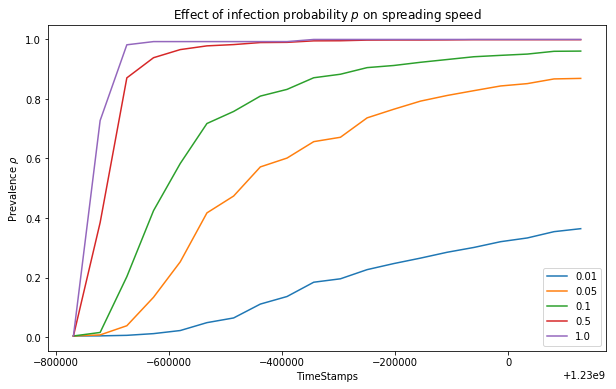

In [82]:
steps = 20
timestamps = np.linspace(min(event_data['StartTime']), max(event_data['EndTime']), steps)

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('TimeStamps')
ax.set_ylabel(r'Prevalence $\rho$')
ax.set_title(r"Effect of infection probability $p$ on spreading speed")
for p, prevalences in prevalence_averages.items():
    plt.plot(list(timestamps), prevalences, label=p)
    ax.legend()

plt.show()

### b) (1 pt) For which infection probabilities does the whole network become fully infected? What are the stepwise, nearly periodic “steps” in the curves due to?

Here we observe how spread speed increase as infection probability $\rho$ increase. The probabilies
- $p=0.5$
- $p=1$
rsults in the whole network being infected.

The period steps might be due a hub being infected hence, causing a higher dispersal of the infection (hubs have
more neighbours)

<a id='task3'></a>
## Task 3: Effect of seed node selection on spreading speed
[Back to content](#content)

Next, we will investigate how the selection of the seed node affects the spreading speed.

### a) (3 pts) Use nodes with node-ids [0, 4, 41, 100, 200] (ABE, ATL, ACN, HSV, DBQ) as seeds and p = 0.1, and run the simulation 10 times for each seed node.
Then, plot the average prevalence of the disease separately for each seed node as a function of time.

In [90]:
p = 0.1
seeds = ['0', '4', '41', '100', '200']
prevalence_averages = {}

for seed_node in seeds:
    print("Calc. for seed node = %s" % seed_node)
    store_prevalence = []
    for _ in range(10):
        graph = simulate_infection(p, seed_node)
        prevalence = calc_prevalence(graph, 20)
        store_prevalence.append(prevalence)

    prevalence_averages[seed_node] = [np.mean(prevalence) for prevalence in zip(*store_prevalence)]

Calc. for seed node = 0
Calc. for seed node = 4
Calc. for seed node = 41
Calc. for seed node = 100
Calc. for seed node = 200


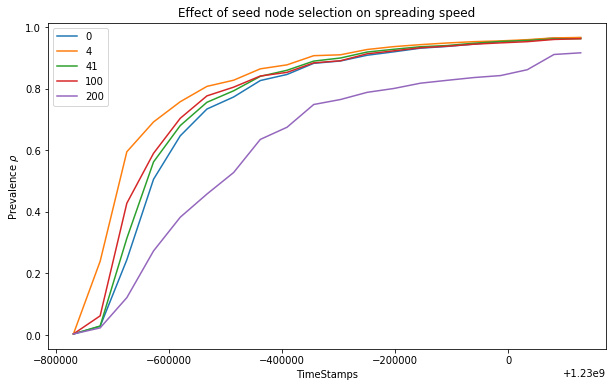

In [91]:
steps = 20
timestamps = np.linspace(min(event_data['StartTime']), max(event_data['EndTime']), steps)

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('TimeStamps')
ax.set_ylabel(r'Prevalence $\rho$')
ax.set_title(r"Effect of seed node selection on spreading speed")
for p, prevalences in prevalence_averages.items():
    plt.plot(list(timestamps), prevalences, label=p)
    ax.legend()

plt.show()

### b) You should be able to see differences in these spreading speed. Are these differences visible in the beginning of the epidemic or only later on? Why?

The differences are more visible at the beginning of the epidemic. Later on, most of the prevalence converge to around 96% (except for choosing node 200)

After overcoming advantages of choosing certain more well connected nodes, the spread speed reached an equilibrium.

### c) In the next tasks, we will, amongst other things, inspect the vulnerability of a node for becoming infected with respect to various network centrality measures. Why is it important to average the results over different seed nodes?

Different seed nodes can affect the spread seed and the vulnerability of a node is not easily observable. For example, some nodes are isolated (such as node ) hence, takes some
time before the infection reaches a hub and spreads quickly. This transient time accounts for
much of the variance.


<a id='task4'></a>
## Task 4: Where to hide?
[Back to content](#content)

Now, consider you want to be as safe from the epidemic as possible. How should you select
your refuge? To answer this question, run your SI-model 50 times with $p = 0.5$ using different
random nodes as seeds and record the median infection times of each node. 

Note that the median infection time is not well defined for nodes that become infected in less than 25 runs.
You may leave those nodes out from your analyses.

### a) Run the 50 simulations, and create scatter plots showing the median infection time of each node as a function of the following nodal network measures:
1. k-shell `nx.core_number(graph)`
2. unweighted clustering coefficient c `nx.clustering(graph)`
3. degree k `graph.degree`
4. strength s `graph.degree(weight='weight')`
5. unweighted betweenness centrality `nx.betweenness_centrality(graph)`
6. closeness centrality `nx.closeness_centrality(graph)`

In [109]:
# run si model 50 times with p = 0.5
# init with different seed nodes (0 - 278)

store_infection_times = {}

p = 0.5
for _ in range(50):
    if _ % 5==0:
        print('iter: %s' % _)
    seed_node = str(np.random.randint(0,279))
    graph = simulate_infection(p, seed_node)
    infection_times = nx.get_node_attributes(graph, 'infection_time')
    for node, infection_time in infection_times.items():
        if node not in store_infection_times:
            store_infection_times[node] = []
        else:
            store_infection_times[node].append(infection_time)

iter: 0
iter: 5
iter: 10
iter: 15
iter: 20
iter: 25
iter: 30
iter: 35
iter: 40
iter: 45


In [119]:
not_infected = {}
store = store_infection_times
for node in store:
    for t in store[node]:
        if t == float('inf'):
            if node in not_infected:
                not_infected[node] +=1
            else:
                not_infected[node] =1

not_infected

{'230': 4, '40': 15}

all nodes infected in at least 25 runs

In [131]:
median_infection_times = {node: 
 np.median([time for time in infection_times if time != float('inf')])
 for node, infection_times in store_infection_times.items()
}

#with open('median.json', 'w') as outfile:
#    json.dump(median_infection_times, outfile)

median_infection_times

{'0': 1229283120.0,
 '1': 1229276520.0,
 '2': 1229277180.0,
 '3': 1229272500.0,
 '4': 1229274000.0,
 '5': 1229278500.0,
 '134': 1229283420.0,
 '135': 1229283060.0,
 '10': 1229278800.0,
 '12': 1229270520.0,
 '15': 1229273340.0,
 '16': 1229275800.0,
 '146': 1229278500.0,
 '19': 1229273580.0,
 '20': 1229280300.0,
 '21': 1229275800.0,
 '24': 1229273400.0,
 '26': 1229278080.0,
 '27': 1229274300.0,
 '28': 1229273400.0,
 '29': 1229279520.0,
 '31': 1229272740.0,
 '32': 1229277240.0,
 '33': 1229279400.0,
 '34': 1229272200.0,
 '7': 1229270880.0,
 '45': 1229282340.0,
 '46': 1229282460.0,
 '47': 1229279700.0,
 '48': 1229274480.0,
 '49': 1229279700.0,
 '50': 1229280300.0,
 '62': 1229280000.0,
 '68': 1229283300.0,
 '70': 1229281500.0,
 '71': 1229275560.0,
 '72': 1229277420.0,
 '77': 1229281740.0,
 '78': 1229280900.0,
 '79': 1229281140.0,
 '80': 1229282100.0,
 '81': 1229281140.0,
 '83': 1229289000.0,
 '85': 1229282220.0,
 '86': 1229281800.0,
 '87': 1229280300.0,
 '90': 1229279100.0,
 '91': 1229281920

In [133]:
graph_info = {
    'k-shell': nx.core_number(graph),
    'unweighted clustering coefficient c': nx.clustering(graph),
    'degree k': dict(graph.degree),
    'strength s': graph.degree(weight='weight'),
    'unweighted betweenness centrality': nx.betweenness_centrality(graph),
    'closeness centrality': nx.closeness_centrality(graph)
}

In [146]:
from sklearn.preprocessing import minmax_scale
from scipy.stats import spearmanr

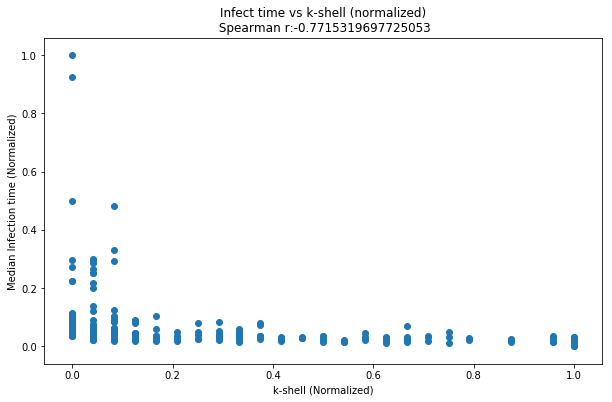

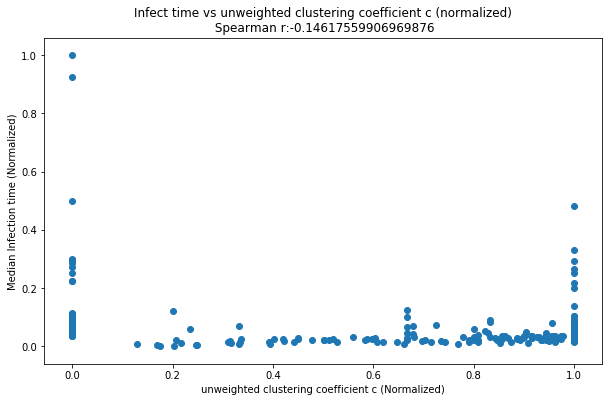

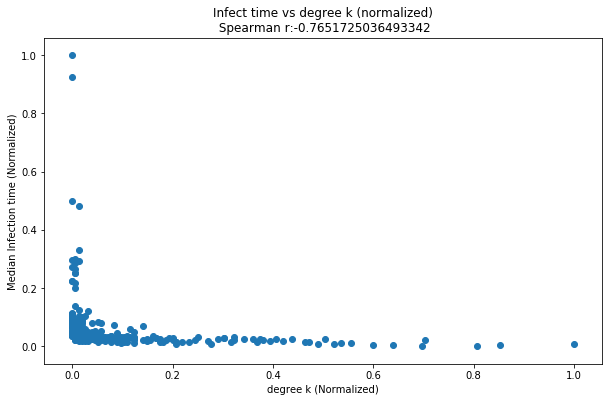

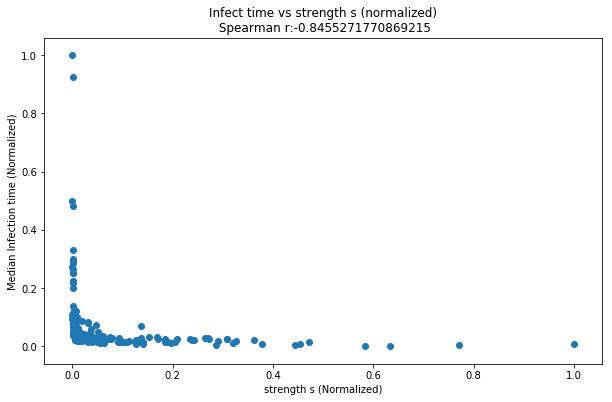

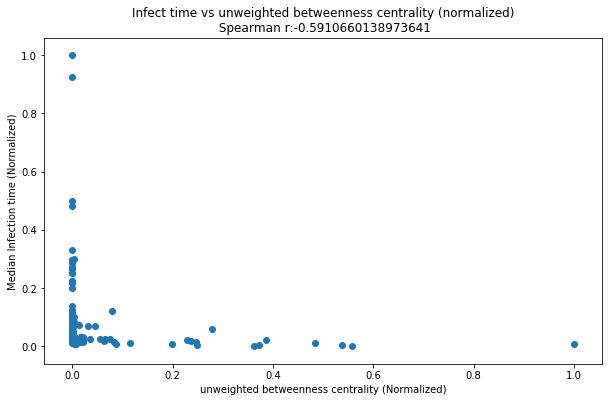

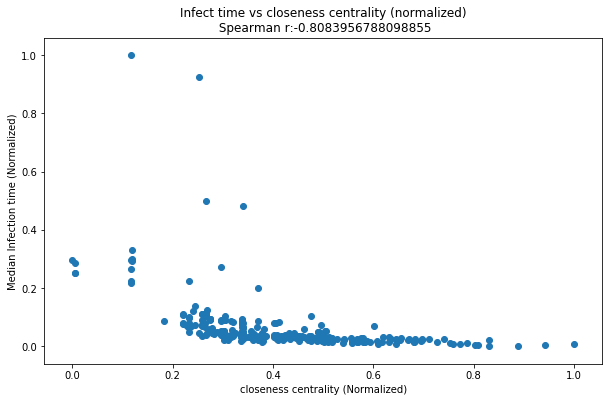

In [161]:
spearmanr_ls = []

for i, (title, info) in enumerate(graph_info.items()):
    x = [info[node] for node in list(graph.nodes)]
    y = [median_infection_times[node] for node in list(graph.nodes)]
    rho = spearmanr(x, y).correlation
    spearmanr_ls.append((title, rho))
    
    x, y = minmax_scale(x), minmax_scale(y)
    plt.figure(figsize=(10,6))
    plt.xlabel(f'{title} (Normalized)')
    plt.ylabel('Median Infection time (Normalized)')
    plt.scatter(x, y)
    plt.title(f'Infect time vs {title} (normalized)\n Spearman r:{rho}')
    
    plt.savefig(f'store/{title}')
    plt.show()

### b)  Use the Spearman rank-correlation coefficient for finding out, which of the measures is the best predictor for the infection times

In [160]:
print('Spearman rank-correlation coefficient for')
for measure, rho in spearmanr_ls:
    print(f'{measure}: {rho}')

Spearman rank-correlation coefficient for
k-shell: -0.7715319697725053
unweighted clustering coefficient c: -0.14617559906969876
degree k: -0.7651725036493342
strength s: -0.8455271770869215
unweighted betweenness centrality: -0.5910660138973641
closeness centrality: -0.8083956788098855


strenght s (rho: -0.845) and closeness centrality (rho: -0.808) seems
better predictors for infection times

### c)  Discuss your results for each network centrality metric. Especially, explain the ranking of the network measures as measured by the median infection time.

<a id='task5'></a>
## Task 5: Shutting down airports
[Back to content](#content)

Now, take the role of a government official considering shutting down airports to prevent the
disease from spreading to the whole country. In our simulations, the shutting down of airports
corresponds to immunization: an airport that has been shut down can not become infected at
any point of the simulation.

One immunization strategy suggested for use in social networks is to 
- pick a random node from the network and immunize one of this focal node’s neighbors. 

Your task is now to compare this strategy against seven other immunization strategies: 
- the immunization of random nodes and
- the immunization of nodes that possess the largest values of the six nodal network measures we used in task 4. 
In this exercise, use $p = 0.5$ and average your results over 20 runs of the model
for each immunization strategy (160 simulations in total).

To reduce the variance due to the selection of seed nodes, use same seed nodes when investigating
each immunization strategy: first select your immunized nodes, and then select 20 random seed
nodes such that none of them belongs to the group of immunized nodes in any of the 8 different
strategies.

    ```
    0: random neighbour (bump up the prob of hubs)
    1: random immunizaion
    2: highest 'k-shell': nx.core_number(graph),
    3: highest 'unweighted clustering coefficient c': nx.clustering(graph),
    4: highest 'degree k': dict(graph.degree),
    5: highest 'strength s': graph.degree(weight='weight'),
    6: highest 'unweighted betweenness centrality': nx.betweenness_centrality(graph),
    7: highest 'closeness centrality': nx.closeness_centrality(graph)
    ```

In [339]:
nodes = list(graph.node)
n_immune = 10

def random_neighbour(n_immune=10):
    r_n = []
    hubs = np.random.choice(nodes, n_immune*2)
    for node in hubs:                
        r_neighbour = np.random.choice(list(graph.neighbors(node)))
        r_n.append(r_neighbour)
    
    r_n = list(set(r_n))
    return np.array(r_n[:n_immune])

immune_nodes = {}

immune_nodes["random_neighbour"] = random_neighbour(n_immune)
immune_nodes["random"] = np.random.choice(nodes, n_immune)

for measure in list(graph_info.keys()):
    print(measure)
    d = dict(graph_info[measure])
    highest_value_nodes = sorted(d.keys(),key=lambda key: d[key], reverse=True)[:n_immune]
    immune_nodes[measure] = np.array(highest_value_nodes)

k-shell
unweighted clustering coefficient c
degree k
strength s
unweighted betweenness centrality
closeness centrality


In [433]:
# select 20 random seed nodes such that none of them belongs
#to the group of immunized nodes in any of the 8 different strategies.

all_immune_nodes = set(np.array([v for k,v in immune_nodes.items()]).flatten())
print(len(all_immune_nodes))

seed_nodes = []
while len(seed_nodes)<20:
    node = np.random.choice(nodes)
    if node not in all_immune_nodes:
        seed_nodes.append(node)
        
print(seed_nodes)

43
['145', '126', '106', '36', '237', '202', '253', '65', '122', '129', '81', '180', '206', '36', '181', '270', '128', '155', '89', '120']


### a)  Adapt your code to enable immunization of nodes, and plot the prevalence of the disease as a function of time for the 8 different immunization strategies (social net., random node, and 6 nodal network measures) when 10 nodes are always immunized

In [440]:
# an airport that is shutdown (immunized) cannot be infect
def simulate_infection_with_immune(p=1, seed_nodes='0', immune_nodes=None):
    # init
    event_data = load_data()
    graph = load_and_init_graph(seed_nodes)
    
    for index in event_data.index:
        row = event_data.iloc[index]
        source, destination, start, end, duration = tuple(row)
        
        # if source or destination is immune, no transmission
        if source in immune_nodes or destination in immune_nodes:
            continue
        
        if (start >= graph.nodes[source]['infection_time']) and (np.random.rand() <= p):
            # only update if new infection time is smaller than target nodes infection time
            if end < graph.nodes[destination]['infection_time']:
                graph.nodes[destination]['infection_time'] = end # update
    return graph

In [519]:
# run si model 20 times (20 seed nodes)
# with p = 0.5
p = 0.5
# for each strategy
store_infection_times_strategy = {}

for strategy in immune_nodes:
    print(f"Calc for strategy: {strategy}")
    i_nodes = immune_nodes[strategy]
    
    store_infection_times = {}
    
    for _ in range(20):
        if _%5==0:
            print(f"{_}/{20}")
        graph = simulate_infection_with_immune(p=p, 
                                               seed_nodes=seed_nodes, 
                                               immune_nodes=i_nodes
                                              )
        
        infection_times = nx.get_node_attributes(graph, 'infection_time')
        
        # store results
        for node, infection_time in infection_times.items():
            if node not in store_infection_times:
                store_infection_times[node] = []
            else:
                store_infection_times[node].append(infection_time)
                
    store_infection_times_strategy[strategy] = store_infection_times
    with open(f'store/{strategy}.pickle', 'wb') as outfile:
        pickle.dump(store_infection_times, outfile)
    
    #with open(f'store/{strategy}.pickle', 'rb') as infile:
    #   b = pickle.load(infile)
    
    print(f"Completed: {strategy}")

Calc for strategy: random_neighbour
0/20
5/20
10/20
15/20
Completed: random_neighbour
Calc for strategy: random
0/20
5/20
10/20
15/20
Completed: random
Calc for strategy: k-shell
0/20
5/20
10/20
15/20
Completed: k-shell
Calc for strategy: unweighted clustering coefficient c
0/20
5/20
10/20
15/20
Completed: unweighted clustering coefficient c
Calc for strategy: degree k
0/20
5/20
10/20
15/20
Completed: degree k
Calc for strategy: strength s
0/20
5/20
10/20
15/20
Completed: strength s
Calc for strategy: unweighted betweenness centrality
0/20
5/20
10/20
15/20
Completed: unweighted betweenness centrality
Calc for strategy: closeness centrality
0/20
5/20
10/20
15/20
Completed: closeness centrality


In [525]:
median_infection_times_strategy = {}

for strategy, store_infection_times in store_infection_times_strategy.items():
    median_infection_times_strategy[strategy] = {
        node: np.median(
        [time for time in infection_times]) 
        for node, infection_times in store_infection_times.items()
    }

In [529]:
# calculate prevalence
steps = 20
timestamps = np.linspace(min(event_data['StartTime']), max(event_data['EndTime']), steps)

prevalence_dic = {}
for strategy, infected_dic in median_infection_times_strategy.items():
    prevalence = []
    for time in timestamps:
        n_infected = len([node for node, infection_time in infected_dic.items() if infection_time <= time])
        prevalence.append(n_infected/N)  
            
    prevalence_dic[strategy] = prevalence
    
for strategy, prevalence in prevalence_dic.items():
    print(strategy)
    print(prevalence)

random_neighbour
[0.06810035842293907, 0.5806451612903226, 0.7741935483870968, 0.8136200716845878, 0.8422939068100358, 0.8422939068100358, 0.8422939068100358, 0.8422939068100358, 0.8422939068100358, 0.8494623655913979, 0.8494623655913979, 0.8494623655913979, 0.8494623655913979, 0.8494623655913979, 0.8494623655913979, 0.8530465949820788, 0.8530465949820788, 0.8530465949820788, 0.8530465949820788, 0.8530465949820788]
random
[0.06810035842293907, 0.7168458781362007, 0.910394265232975, 0.9390681003584229, 0.956989247311828, 0.956989247311828, 0.956989247311828, 0.956989247311828, 0.956989247311828, 0.96415770609319, 0.96415770609319, 0.96415770609319, 0.96415770609319, 0.96415770609319, 0.96415770609319, 0.96415770609319, 0.96415770609319, 0.96415770609319, 0.96415770609319, 0.96415770609319]
k-shell
[0.06810035842293907, 0.5698924731182796, 0.7777777777777778, 0.8172043010752689, 0.8207885304659498, 0.8243727598566308, 0.8243727598566308, 0.8243727598566308, 0.8243727598566308, 0.83870967

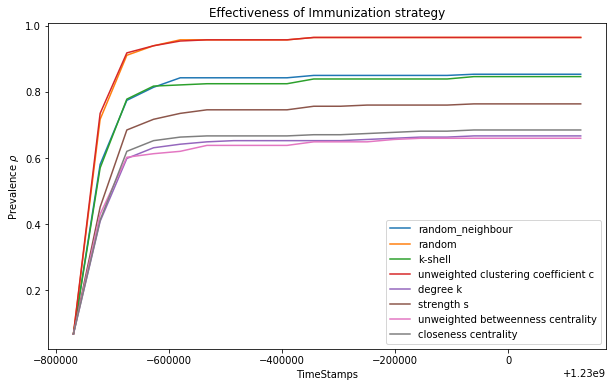

In [540]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('TimeStamps')
ax.set_ylabel(r'Prevalence $\rho$')
ax.set_title(r"Effectiveness of Immunization strategy")
for strategy, prevalences in prevalence_dic.items():
    ax.plot(list(timestamps), prevalences, label=strategy)
    ax.legend()
    
fig.savefig("immune_strategy")

In [570]:
print("Max prevalence:")
final_prevalence = [(strategy, round(max(prevalence),3)) for strategy, prevalence in prevalence_dic.items()]
sorted_final_prevalence = sorted(final_prevalence, key=lambda x: x[1])
sorted_final_prevalence

Max prevalence:


[('unweighted betweenness centrality', 0.659),
 ('degree k', 0.667),
 ('closeness centrality', 0.685),
 ('strength s', 0.763),
 ('k-shell', 0.846),
 ('random_neighbour', 0.853),
 ('random', 0.964),
 ('unweighted clustering coefficient c', 0.964)]

In [571]:
print('Spearman rank-correlation coefficient for')
sorted_spearmanr_ls = sorted([(k,round(v,3)) for k,v in spearmanr_ls], key=lambda x: x[1])
sorted_spearmanr_ls

Spearman rank-correlation coefficient for


[('strength s', -0.846),
 ('closeness centrality', -0.808),
 ('k-shell', -0.772),
 ('degree k', -0.765),
 ('unweighted betweenness centrality', -0.591),
 ('unweighted clustering coefficient c', -0.146)]

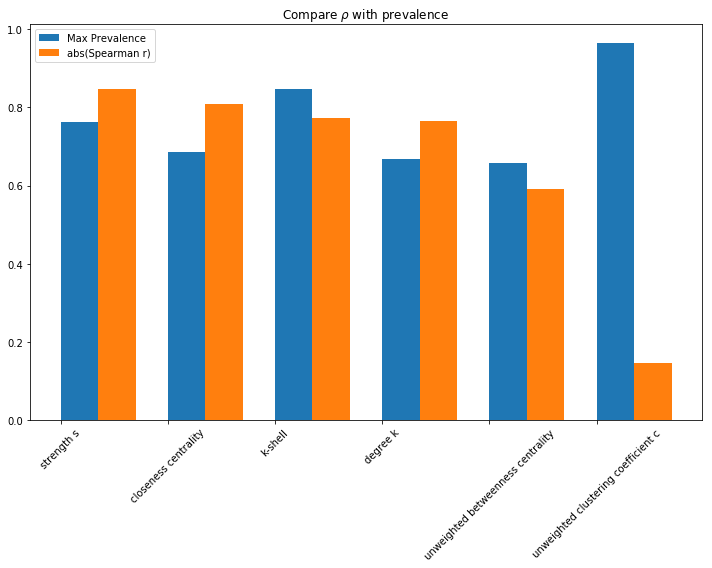

In [618]:
# data to plot
n_groups = 6
 
# create plot
fig, ax = plt.subplots(figsize=(10,8))
index = np.arange(n_groups)
bar_width = 0.35

val1 = [dict(sorted_final_prevalence)[i] for i,j in sorted_spearmanr_ls]
val2 = [-j for i,j in sorted_spearmanr_ls]

rects1 = plt.bar(index, val1, bar_width,
                 label='Max Prevalence')
 
rects2 = plt.bar(index + bar_width, val2, bar_width,
                 label='abs(Spearman r)')
 
plt.title(r'Compare $\rho$ with prevalence')
plt.xticks(index-bar_width/2, 
           [i for i,j in sorted_spearmanr_ls], rotation='45')
plt.legend()

fig.tight_layout()
fig.savefig('compare.png')

plt.show()

<a id='task6'></a>
## Task 6: Disease transmitting link
[Back to content](#content)

So far we have only analyzed the importance of network nodes, but next we will discuss the role
of links. 

We do this by recording the number of times each link transmits the disease to another
node. 

So adapt your code to recording the (undirected) links which are used to transmit the
disease. 

This is best done by storing for each node where it obtained the infection. 

Run 20 simulations using random nodes as seeds and p = 0.5. For each simulation, record which links are used to infect yet uninfected airports.

In [718]:
def simulate_infection_2(p=1, seed_nodes='0', immune_nodes=[]):
    # tracks edge
    # init
    event_data = load_data()
    graph = load_and_init_graph(seed_nodes)
    nx.set_edge_attributes(graph, {edge: None for edge in graph.edges}, 'infection_from')
    
    for index in event_data.index:
        row = event_data.iloc[index]
        source, destination, start, end, duration = tuple(row)
        
        # if source or destination is immune, no transmission
        if source in immune_nodes or destination in immune_nodes:
            continue
        
        if (start >= graph.nodes[source]['infection_time']) and (np.random.rand() <= p):
            # only update if new infection time is smaller than target nodes infection time
            if end < graph.nodes[destination]['infection_time']:
                graph.nodes[destination]['infection_time'] = end # update
                
                # infect an uninfected airport
                graph.get_edge_data(source, destination)['infection_from'] = source
                
    return graph

### a) Run the simulations, and compute the fraction of times each link is used for infecting the disease ($f_{ij}$).
Then use the provided function plot_network_USA which can be found
in si_animator.py to visualize the network on top of the US map. Adjust the width of
the links according to the fractions f ij to better see the overall structure. Compare your
visualization with the maximal spanning tree of the network.

In [707]:
p = 0.5
seed_nodes = np.random.choice(nodes, 20)

In [792]:
transmission_count = {edge: 0 for edge in graph.edges}
# Run 20 simulations using random nodes as seeds and p = 0.5. 
# For each simulation, record which links are used to infect yet uninfected airports.
for i, seed in enumerate(seed_nodes):
    if i%5==0:
        print(f'{i}/{len(seed_nodes)}')
        
    graph = simulate_infection_2(p, seed_nodes=str(seed), immune_nodes=[])
    
    for edge, source in nx.get_edge_attributes(graph, 'infection_from').items():
        if source != None:
            transmission_count[edge] += 1

0/20
5/20
10/20
15/20


In [794]:
from si_animator import plot_network_usa

In [798]:
airport = pd.read_csv('US_airport_id_info.csv')
airport.head()

,id,symbol,airport name,city,latitude,longitude,xcoordviz,ycoordviz
0,0,ABE,Lehigh Valley Intl,Allentown,40.652083,-75.440806,1.926093e+06,337357.529978
1,1,CLE,Cleveland Hopkins Intl,Cleveland,41.411689,-81.849794,1.384469e+06,302554.338074
2,2,CLT,Charlotte Douglas Intl,Charlotte,35.214000,-80.943139,1.590611e+06,-355004.415565
3,3,ORD,Chicago Ohare Intl,Chicago,41.978603,-87.904842,8.790187e+05,289127.727396
4,4,ATL,Hartsfield Jackson Atlanta Intl,Atlanta,33.636719,-84.428067,1.306257e+06,-582505.812325


In [810]:
xycoords = {str(airport.id[index]):
 (airport.xcoordviz[index],airport.ycoordviz[index])
 for index in airport.index}

edges = list(graph.edges)

widths = [transmission_count[edge]/20 for edge in edges]

/home/adam/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


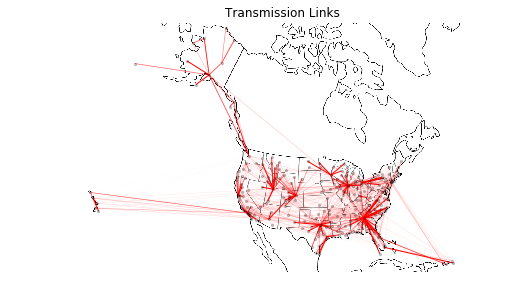

In [813]:
plot_network_usa(graph, xycoords, edges=edges, linewidths=widths)
plt.title("Transmission Links")
plt.savefig('store/plot_network_usa.png')

/home/adam/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


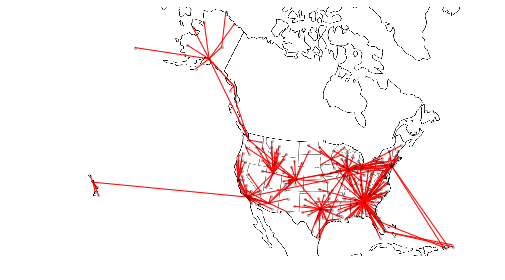

In [814]:
mst = nx.maximum_spanning_tree(graph)
mst_edges = list(mst.edges)
plot_network_usa(mst, xycoords, 
                 mst_edges, [1 for _ in mst_edges])
plt.savefig('store/plot_mst.png')

### b)What do you notice? How would you explain your finding?

The mst and our graph happens to coincide with each other approximately. Since maximal spanning tree
has all edges and the max weight, to obtain this max weight, we reach a hub can traverse the edges to nodes in
the region. 

This is similar to how disease spreads quickly, by infecting a hub and infecting the region.

### c) Create scatter plots showing $f_{ij}$ as a function of the following link properties:

i) link weight $w_{ij}$

ii) link neighborhood overlap $O_{ij}$

iii) _unweighted_ link betweenness centrality $eb_{ij}$

In [842]:
edges = list(graph.edges())

edge_info = {
    'weight': nx.get_edge_attributes(graph, 'weight'),
    'link neighborhood overlap' : {
        (u, v): len(list(nx.common_neighbors(graph, u, v))) / len(set(graph.neighbors(u)) | set(graph.neighbors(v)))
        for u, v in edges
    },
    'link betweenness centrality' : nx.edge_betweenness_centrality(graph)
}

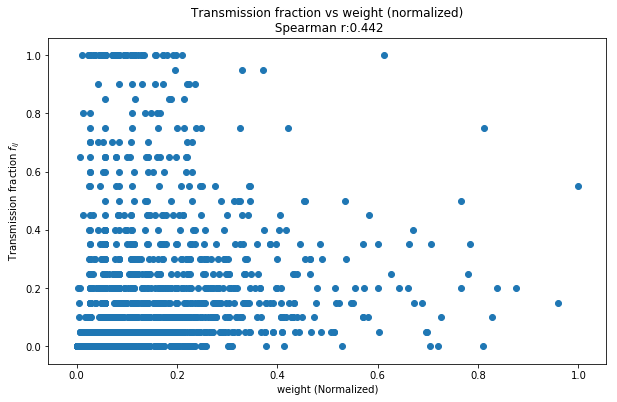

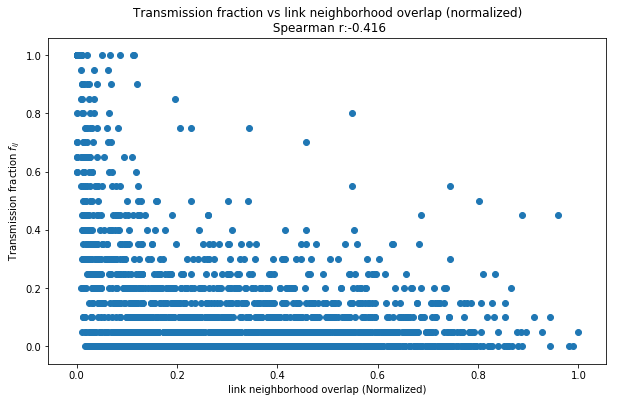

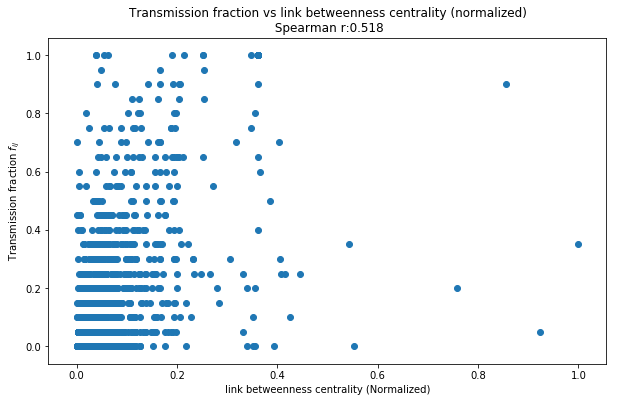

In [850]:
spearmanr_ls_links = []

for attribute, info in edge_info.items():
    x = minmax_scale([info[edge] for edge in edges])
    y = widths
    rho = spearmanr(x, y).correlation
    spearmanr_ls_links.append((attribute, rho))
    
    plt.figure(figsize=(10,6))
    plt.xlabel(f'{attribute} (Normalized)')
    plt.ylabel(r'Transmission fraction $f_{ij}$')
    plt.scatter(x, y)
    plt.title(f'Transmission fraction vs {attribute} (normalized)\n Spearman r:{round(rho,3)}')
    
    plt.savefig(f'store/{attribute}')
    plt.show()

In [851]:
# Compute also the Spearman correlation coefficients between f ij 
# and the three link-wise measures.
spearmanr_ls_links

[('weight', 0.4418235197348032),
 ('link neighborhood overlap', -0.41601322267094554),
 ('link betweenness centrality', 0.5181664882192158)]

### d)  Explain the performance of the three link properties for predicting $f_{ij}$ .
`widths`

All 3 measures are not too food in predicting $f_{ij}$. Link betweenness
it the best performing because it is the sum of the fraction of all-pairs shortest paths that pass through 

## BONUS task
None of the above measures was extremely good for predicting $f_{ij}$ . 

As a bonus task, you can
come up with a measure of your own, or find out an appropriate measure from the literature that
you think is better for predicting $f_{ij}$ than the three measures listed above. 

Motivate selection of method, and perform similar investigations as with the other link properties. 

Especially evaluate the Spearman correlation between the measure you developed and $f_{ij}$ .


fraction of times each link is used for infecting the disease ($f_{ij}$).

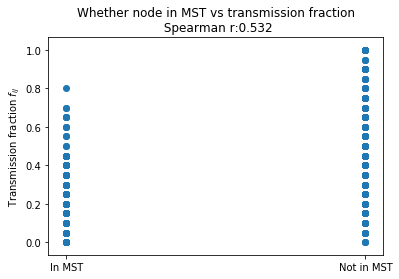

In [1009]:
in_mst = [1 if edge in list(mst.edges) else 0 for edge in edges]
y = widths
rho = spearmanr(in_mst, y).correlation
plt.scatter(in_mst, y)
plt.xticks(np.arange(2), ('In MST', 'Not in MST'))
          
plt.ylabel(r'Transmission fraction $f_{ij}$')
plt.title(f'Whether node in MST vs transmission fraction\n Spearman r:{round(rho,3)}')

plt.savefig(f'store/mst')

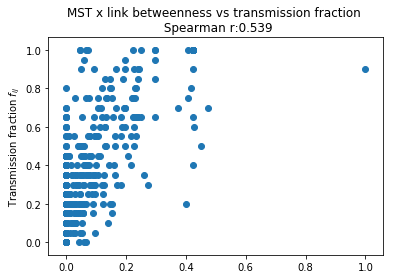

In [1010]:
x = [edge_info['link betweenness centrality'][edge] if edge in list(mst.edges) else 0 for edge in edges ]
x = minmax_scale(x)
y = widths
rho = spearmanr(x, y).correlation
plt.scatter(x, y)

plt.ylabel(r'Transmission fraction $f_{ij}$')
plt.title(f'MST x link betweenness vs transmission fraction \n Spearman r:{round(rho,3)}')
plt.savefig(f'store/mstbetween')

Both methods increase spearman coefficient insignificantly

# Graph clustering

**input**: graph adjacency matrix $A$, number $k$
1. form diagonal matrix $D$
2. form unnormalized Laplacian $L = D − A$

3. compute the first $k$ eigenvectors $u_1 , \dots, u_k$ of the
_generalized eigenproblem_ $L \mathbf{u} = \lambda D \mathbf{u}$
(eigenvectors of $L_{rw}$)

4. form matrix $U \in \texttt{R}^{n \times k}$ with columns $u_1, \dots, u_k$
5. Normalize $U$ such that rows have norm 1
6. consider the i-th row of $U$ as point $y_i \in \texttt{R}^k, \; i=1, \dots, n$
7. cluster (kmeans) the points $\{y_i\}_{i=1, \dots, n}$ into clusters $C_1, \dots, C_k$

**output** clusters $A_1, \dots A_k$

$L_{rw} := I - D^{-1} A$

`d_inverse` $= D^{-1}$ 

In [882]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [923]:
def spectral_graph_clustering(graph, k):
    """
    k: no. of 
    """
    # form adjacency matrix A and diagonal matrix D
    adjacency_matrix = nx.adjacency_matrix(graph)
    diagonal_matrix = np.diag(np.ravel(np.sum(adjacency_matrix, axis = 1)))

    identity_matrix = np.identity(adjacency_matrix.shape[0])

    # form laplacian_rw
    d_inverse = np.linalg.inv(diagonal_matrix)
    laplacian = np.subtract(identity_matrix, d_inverse@adjacency_matrix)

    # first k eigenvectors of L
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian)
    u = eigenvectors[:, :k]

    # normalize U so that rows have norm 1
    u = normalize(u, axis=1, norm='l1')

    kmeans = KMeans(n_clusters=k).fit(u)
    labels = kmeans.labels_
    
    return labels

def calc_partition_cost(graph, labels):
    counts = {}
    for label in labels:
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    
    cuts = 0
        
    for (u, v) in list(graph.edges):
        # if u and v not same cluster
        if labels[int(u)] != labels[int(v)]:
            cuts += 1
    min_cluster_size = min(counts.values())
    partition_cost = cuts/ min_cluster_size
        

    print('Cluster counts: \n%s' % counts)
    print('No. of cuts: %s' % cuts) 
    print('Cost: %s' % partition_cost)
        
    return partition_cost

In [931]:
costs = []
for k in range(1,20):
    labels = spectral_graph_clustering(graph, k)
    costs.append(calc_partition_cost(graph, labels))

Cluster counts: 
{0: 279}
No. of cuts: 0
Cost: 0.0
Cluster counts: 
{0: 117, 1: 162}
No. of cuts: 1010
Cost: 8.632478632478632
Cluster counts: 
{0: 118, 2: 65, 1: 96}
No. of cuts: 1239
Cost: 19.06153846153846
Cluster counts: 
{0: 92, 2: 56, 1: 88, 3: 43}
No. of cuts: 1452
Cost: 33.76744186046512
Cluster counts: 
{0: 86, 3: 54, 2: 34, 1: 60, 4: 45}
No. of cuts: 1449
Cost: 42.61764705882353
Cluster counts: 
{2: 79, 3: 53, 1: 33, 4: 43, 0: 27, 5: 44}
No. of cuts: 1495
Cost: 55.370370370370374
Cluster counts: 
{3: 52, 0: 41, 1: 40, 5: 33, 2: 43, 4: 27, 6: 43}
No. of cuts: 1647
Cost: 61.0
Cluster counts: 
{2: 51, 7: 42, 1: 40, 0: 25, 3: 42, 4: 17, 6: 21, 5: 41}
No. of cuts: 1667
Cost: 98.05882352941177
Cluster counts: 
{6: 53, 0: 41, 2: 42, 1: 23, 3: 30, 4: 17, 7: 21, 5: 38, 8: 14}
No. of cuts: 1660
Cost: 118.57142857142857
Cluster counts: 
{5: 48, 0: 41, 7: 39, 1: 32, 2: 29, 3: 17, 8: 22, 6: 12, 9: 9, 4: 30}
No. of cuts: 1682
Cost: 186.88888888888889
Cluster counts: 
{1: 17, 8: 49, 10: 36,

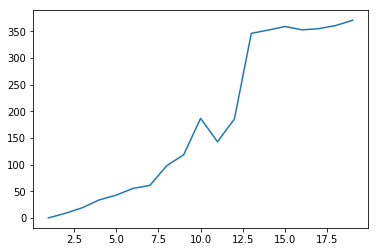

In [932]:
plt.plot(range(1,20), costs)

In [968]:
labels = spectral_graph_clustering(graph, 11)
calc_partition_cost(graph, labels)

Cluster counts: 
{5: 17, 10: 49, 6: 36, 0: 31, 1: 26, 9: 29, 4: 17, 8: 19, 3: 24, 7: 12, 2: 19}
No. of cuts: 1715
Cost: 142.91666666666666


142.91666666666666

In [994]:
def plot_nodes_colour(net, xycoords, labels, edges=None, linewidths=None):
    """
    Plot the network usa.
    The file US_air_bg.png should be located in the same directory
    where you run the code.

    Parameters
    ----------
    net : the network to be plotted
    xycoords : dictionary of node_id to coordinates (x,y)
    edges : list of node index tuples (node_i,node_j),
            if None all network edges are plotted.
    linewidths : see nx.draw_networkx documentation
    """
    cmap = np.random.choice(list(mcolors.XKCD_COLORS.values()),len(labels))
    
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 0.9])
    # ([0, 0, 1, 1])
    bg_figname = 'US_air_bg.png'
    img = plt.imread(bg_figname)
    axis_extent = (-6674391.856090588, 4922626.076444283,
                   -2028869.260519173, 4658558.416671531)
    ax.imshow(img, extent=axis_extent)
    ax.set_xlim((axis_extent[0], axis_extent[1]))
    ax.set_ylim((axis_extent[2], axis_extent[3]))
    ax.set_axis_off()
    nx.draw_networkx_nodes(net,
                     pos=xycoords,
                     with_labels=False,
                     node_color=[cmap[label] for label in labels],
                     node_size=5)
    if linewidths == None:
        linewidths = np.ones(len(edges))

    for edge, lw  in zip(edges, linewidths):
        nx.draw_networkx_edges(
            net,
            pos=xycoords,
            with_labels=True,
            edge_color='k',
            width=lw,
            edgelist=[edge],
            alpha=lw,
        )
    return fig, ax

/home/adam/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


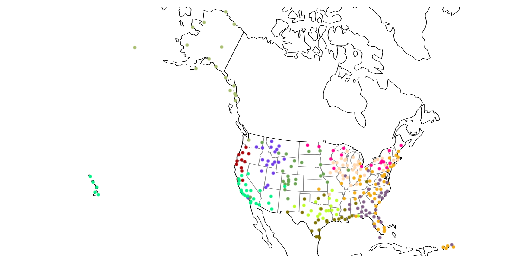

In [1017]:
plot_nodes_colour(graph, xycoords, labels,
                 edges=edges, linewidths=[0 for node in nodes])

plt.savefig("store/cluster")